# Моделирование

# 0. Импорт сторонних библиотек

In [3]:
import pandas as pd
import numpy as np
from functools import partial
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from hyperopt import fmin, tpe, hp, SparkTrials, STATUS_OK, Trials
import matplotlib.pyplot as plt
import itertools
import mlflow
import hyperopt
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score, confusion_matrix 

import warnings
warnings.filterwarnings('ignore')

## 0.1 Настройки среды, объявление глобальных переменных и функций

In [4]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

RANDOM_SEED = 42

In [5]:

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
 
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
 
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# 1. Чтение подготовленного датасета

In [6]:
df_final = pd.read_csv('../data/df_final_sc.csv')
df_final.head()

,Attrition,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,Gender_Female,Gender_Male,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes,Age_category_Middle,Age_category_Old,Age_category_Young,DailyRate_category_High,DailyRate_category_Middle,DailyRate_category_Small,DistanceFromHome_category_Close,DistanceFromHome_category_Far,DistanceFromHome_category_Middle,Education_category_High,Education_category_Middle,Education_category_Small,EnvironmentSatisfaction_category_Doesnot_Satisfied,EnvironmentSatisfaction_category_Middle,HourlyRate_category_High,HourlyRate_category_Middle,HourlyRate_category_Small,JobInvolvement_category_High,JobInvolvement_category_Middle,JobInvolvement_category_Small,JobLevel_category_High,JobLevel_category_Middle,JobLevel_category_Small,JobSatisfaction_category_Doesnot_Satisfied,JobSatisfaction_category_Middle,MonthlyIncome_category_High,MonthlyIncome_category_Middle,MonthlyIncome_category_Small,MonthlyRate_category_High,MonthlyRate_category_Middle,MonthlyRate_category_Small,NumCompaniesWorked_category_Few,NumCompaniesWorked_category_Many,NumCompaniesWorked_category_Middle,PercentSalaryHike_category_High,PercentSalaryHike_category_Middle,PercentSalaryHike_category_Small,PerformanceRating_category_High,PerformanceRating_category_Small,RelationshipSatisfaction_category_Doesnot_Satisfied,RelationshipSatisfaction_category_Middle,StockOptionLevel_category_High,StockOptionLevel_category_Middle,StockOptionLevel_category_Small,TotalWorkingYears_category_Few,TotalWorkingYears_category_Many,TotalWorkingYears_category_Middle,TrainingTimesLastYear_category_Few,TrainingTimesLastYear_category_Many,TrainingTimesLastYear_category_Middle,WorkLifeBalance_category_High,WorkLifeBalance_category_Middle,WorkLifeBalance_category_Small,YearsAtCompany_category_Few,YearsAtCompany_category_Many,YearsAtCompany_category_Middle,YearsInCurrentRole_category_Few,YearsInCurrentRole_category_Many,YearsInCurrentRole_category_Middle,YearsSinceLastPromotion_category_Few,YearsSinceLastPromotion_category_Many,YearsSinceLastPromotion_category_Middle,YearsWithCurrManager_category_Few,YearsWithCurrManager_category_Many,YearsWithCurrManager_category_Middle,std_Age,std_DailyRate,std_DistanceFromHome,std_Education,std_EnvironmentSatisfaction,std_HourlyRate,std_JobInvolvement,std_JobLevel,std_JobSatisfaction,std_MonthlyIncome,std_MonthlyRate,std_NumCompaniesWorked,std_PercentSalaryHike,std_PerformanceRating,std_RelationshipSatisfaction,std_StockOptionLevel,std_TotalWorkingYears,std_TrainingTimesLastYear,std_WorkLifeBalance,std_YearsAtCompany,std_YearsInCurrentRole,std_YearsSinceLastPromotion,std_YearsWithCurrManager
0,1,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,1,0,0,0,1,0,1,0,0,0,0,1,1,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,1,1,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,1,0.446350,0.742527,-1.010909,-0.891688,-0.660531,1.383138,0.379672,-0.057788,1.153254,-0.108350,0.726020,2.125136,-1.150554,-0.426230,-1.584178,-0.932014,-0.421642,-2.171982,-2.493820,-0.164613,-0.063296,-0.679146,0.245834
1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,1.322365,-1.297775,-0.147150,-1.868426,0.254625,-0.240677,-1.026167,-0.057788,-0.660853,-0.291719,1.488876,-0.678049,2.129306,2.346151,1.191438,0.241988,-0.164511,0.155707,0.338096,0.488508,0.764998,-

# 2. Разбиение датасета на тестовую и тренировочную выборки в соотношении 20/80

In [7]:
df_train, df_test = train_test_split(df_final, stratify=df_final['Attrition'], test_size=0.2, random_state=RANDOM_SEED)

X_train = df_train.drop('Attrition', axis = 1)
y_train = df_train['Attrition']

X_test = df_test.drop('Attrition', axis = 1)
y_test = df_test['Attrition']

In [8]:
print(f'Размерность выборок:\nТренировочная: {X_train.shape[0]} x {X_train.shape[1] + 1}\nТестовая: {X_test.shape[0]} x {X_test.shape[1] + 1}')

Размерность выборок:
Тренировочная: 1176 x 117
Тестовая: 294 x 117


# 2. Объявление моделей и сравнение результатов

In [6]:
log_reg_model = LogisticRegression(n_jobs=-1, random_state=RANDOM_SEED)
r_f_model = RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state = RANDOM_SEED)
hgbc_model = HistGradientBoostingClassifier(class_weight = 'balanced',  scoring = 'accuracy', random_state=RANDOM_SEED)
mlp_model = MLPClassifier(shuffle = True, early_stopping = True, random_state = RANDOM_SEED)
svc_model = SVC(class_weight='balanced', probability = True, random_state=RANDOM_SEED)
cat_boosting_model = CatBoostClassifier(iterations=1000, learning_rate=0.01, depth=7, l2_leaf_reg=9, 
                              bootstrap_type='Bayesian', loss_function='Logloss', eval_metric='Accuracy', 
                              auto_class_weights='Balanced', allow_writing_files=False, silent = True)

models = [log_reg_model, r_f_model, hgbc_model, mlp_model, svc_model, cat_boosting_model]

In [7]:
for model in models:
    model.fit(X_train, y_train)
    y_pred_test = model.predict(X_test)
    y_pred_prob_test = model.predict_proba(X_test) 
    accuracy_score_test = accuracy_score(y_test, y_pred_test)
    f1_test = f1_score(y_test, y_pred_test)
    precision_test = precision_score(y_test, y_pred_test)
    recall_test = recall_score(y_test, y_pred_test)
    roc_auc_test = roc_auc_score(y_test, y_pred_prob_test[:, 1])
    
    print(f'Модель: {type(model).__name__}\nAccuracy: {accuracy_score_test}\nf1 score: {f1_test}\nPrecision: {precision_test}\nRecall: {recall_test}\nROC_AUC: {roc_auc_test}\n')

Модель: LogisticRegression
Accuracy: 0.8809523809523809
f1 score: 0.5070422535211269
Precision: 0.75
Recall: 0.3829787234042553
ROC_AUC: 0.8470152467912826

Модель: RandomForestClassifier
Accuracy: 0.8469387755102041
f1 score: 0.11764705882352941
Precision: 0.75
Recall: 0.06382978723404255
ROC_AUC: 0.7971832199155827

Модель: HistGradientBoostingClassifier
Accuracy: 0.8605442176870748
f1 score: 0.48101265822784806
Precision: 0.59375
Recall: 0.40425531914893614
ROC_AUC: 0.7739684727366698

Модель: MLPClassifier
Accuracy: 0.8809523809523809
f1 score: 0.4615384615384616
Precision: 0.8333333333333334
Recall: 0.3191489361702128
ROC_AUC: 0.810319579636489

Модель: SVC
Accuracy: 0.8537414965986394
f1 score: 0.5656565656565657
Precision: 0.5384615384615384
Recall: 0.5957446808510638
ROC_AUC: 0.8508915496597467

Модель: CatBoostClassifier
Accuracy: 0.8571428571428571
f1 score: 0.5
Precision: 0.5675675675675675
Recall: 0.44680851063829785
ROC_AUC: 0.8165216642260315



# 3. Тюнинг параметров лидирующих моделей в ручном режиме

In [10]:
log_reg_model = LogisticRegression(C = 0.1, n_jobs=-1, random_state=RANDOM_SEED)
mlp_model = MLPClassifier(solver = 'adam', activation = 'relu', hidden_layer_sizes= [100, 100], shuffle = True, early_stopping = True, random_state = RANDOM_SEED)
models = [log_reg_model, mlp_model]

In [11]:
for model in models:
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    y_pred_prob_test = model.predict_proba(X_test) 
    accuracy_score_test = accuracy_score(y_test, y_pred_test)
    accuracy_score_train = accuracy_score(y_train, y_pred_train)
    f1_test = f1_score(y_test, y_pred_test)
    precision_test = precision_score(y_test, y_pred_test)
    recall_test = recall_score(y_test, y_pred_test)
    roc_auc_test = roc_auc_score(y_test, y_pred_prob_test[:, 1])
    
    print(f'Модель: {type(model).__name__}\nAccuracy_train: {accuracy_score_train}\nAccuracy_test: {accuracy_score_test}\nf1 score: {f1_test}\nPrecision: {precision_test}\nRecall: {recall_test}\nROC_AUC: {roc_auc_test}\n')

Модель: LogisticRegression
Accuracy_train: 0.9064625850340136
Accuracy_test: 0.8843537414965986
f1 score: 0.46875
Precision: 0.8823529411764706
Recall: 0.3191489361702128
ROC_AUC: 0.8527004909983634

Модель: MLPClassifier
Accuracy_train: 0.9260204081632653
Accuracy_test: 0.8945578231292517
f1 score: 0.5633802816901409
Precision: 0.8333333333333334
Recall: 0.425531914893617
ROC_AUC: 0.8192781462658283



In [12]:
mlp_model.fit(X_train, y_train)
y_pred_train = mlp_model.predict(X_train)
y_pred_test =mlp_model.predict(X_test)
y_pred_prob_test = mlp_model.predict_proba(X_test) 
accuracy_score_test = accuracy_score(y_test, y_pred_test)
accuracy_score_train = accuracy_score(y_train, y_pred_train)
f1_test = f1_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
roc_auc_test = roc_auc_score(y_test, y_pred_prob_test[:, 1])
    
print(f'Модель: {type(mlp_model).__name__}\nAccuracy_train: {accuracy_score_train}\nAccuracy_test: {accuracy_score_test}\nf1 score: {f1_test}\nPrecision: {precision_test}\nRecall: {recall_test}\nROC_AUC: {roc_auc_test}\n')

Модель: MLPClassifier
Accuracy_train: 0.9260204081632653
Accuracy_test: 0.8945578231292517
f1 score: 0.5633802816901409
Precision: 0.8333333333333334
Recall: 0.425531914893617
ROC_AUC: 0.8192781462658283



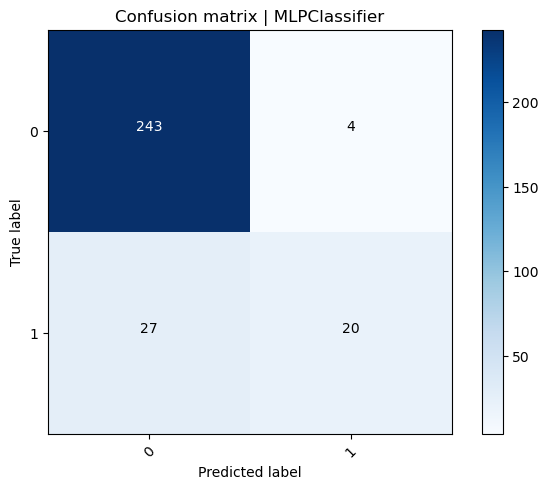

In [13]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred_test), classes=['0','1'],
                      title='Confusion matrix | MLPClassifier')

In [14]:
log_reg_model.fit(X_train, y_train)
y_pred_train = log_reg_model.predict(X_train)
y_pred_test =log_reg_model.predict(X_test)
y_pred_prob_test = log_reg_model.predict_proba(X_test) 
accuracy_score_test = accuracy_score(y_test, y_pred_test)
accuracy_score_train = accuracy_score(y_train, y_pred_train)
f1_test = f1_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
roc_auc_test = roc_auc_score(y_test, y_pred_prob_test[:, 1])
    
print(f'Модель: {type(log_reg_model).__name__}\nAccuracy_train: {accuracy_score_train}\nAccuracy_test: {accuracy_score_test}\nf1 score: {f1_test}\nPrecision: {precision_test}\nRecall: {recall_test}\nROC_AUC: {roc_auc_test}\n')

Модель: LogisticRegression
Accuracy_train: 0.9064625850340136
Accuracy_test: 0.8843537414965986
f1 score: 0.46875
Precision: 0.8823529411764706
Recall: 0.3191489361702128
ROC_AUC: 0.8527004909983634



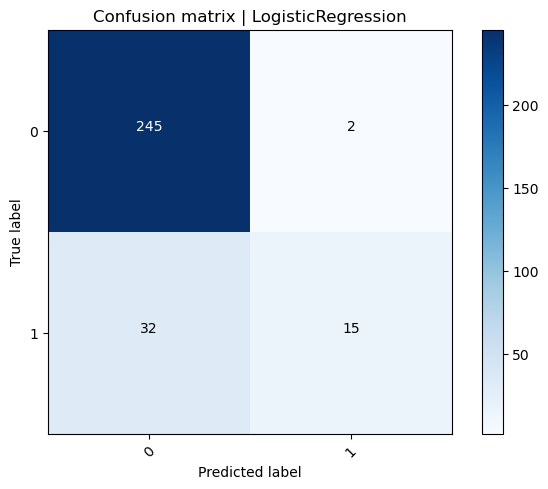

In [15]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred_test), classes=['0','1'],
                      title='Confusion matrix | LogisticRegression')

In [16]:
hgbc_model = HistGradientBoostingClassifier(loss = 'log_loss', class_weight = 'balanced',  scoring = 'accuracy', random_state=RANDOM_SEED)
hgbc_model.fit(X_train, y_train)
y_pred_train = hgbc_model.predict(X_train)
y_pred_test =hgbc_model.predict(X_test)
y_pred_prob_test = hgbc_model.predict_proba(X_test) 
accuracy_score_test = accuracy_score(y_test, y_pred_test)
accuracy_score_train = accuracy_score(y_train, y_pred_train)
f1_test = f1_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
roc_auc_test = roc_auc_score(y_test, y_pred_prob_test[:, 1])
    
print(f'Модель: {type(hgbc_model).__name__}\nAccuracy_train: {accuracy_score_train}\nAccuracy_test: {accuracy_score_test}\nf1 score: {f1_test}\nPrecision: {precision_test}\nRecall: {recall_test}\nROC_AUC: {roc_auc_test}\n')

Модель: HistGradientBoostingClassifier
Accuracy_train: 1.0
Accuracy_test: 0.8605442176870748
f1 score: 0.48101265822784806
Precision: 0.59375
Recall: 0.40425531914893614
ROC_AUC: 0.7739684727366698



# 4. Эксперимент по генерации дополнительных примеров тренировочной выборки

In [9]:
os = SMOTE(random_state=RANDOM_SEED)
features = df_train.columns.to_list()
features.remove('Attrition')
target = 'Attrition'
X_train, y_train = os.fit_resample(df_train[features], df_train[target])

In [10]:
print(f'Размерность выборок:\nТренировочная: {X_train.shape[0]} x {X_train.shape[1] + 1}\nТестовая: {X_test.shape[0]} x {X_test.shape[1] + 1}')

Размерность выборок:
Тренировочная: 1972 x 117
Тестовая: 294 x 117


In [18]:
mlp_model = MLPClassifier(solver = 'adam', activation = 'relu', hidden_layer_sizes= [100, 100], shuffle = True, early_stopping = True, random_state = RANDOM_SEED)

In [19]:
mlp_model.fit(X_train, y_train)
y_pred_train = mlp_model.predict(X_train)
y_pred_test =mlp_model.predict(X_test)
y_pred_prob_test = mlp_model.predict_proba(X_test) 
accuracy_score_test = accuracy_score(y_test, y_pred_test)
accuracy_score_train = accuracy_score(y_train, y_pred_train)
f1_test = f1_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
roc_auc_test = roc_auc_score(y_test, y_pred_prob_test[:, 1])
    
print(f'Модель: {type(mlp_model).__name__}\nAccuracy_train: {accuracy_score_train}\nAccuracy_test: {accuracy_score_test}\nf1 score: {f1_test}\nPrecision: {precision_test}\nRecall: {recall_test}\nROC_AUC: {roc_auc_test}\n')

Модель: MLPClassifier
Accuracy_train: 0.9629817444219066
Accuracy_test: 0.9013605442176871
f1 score: 0.6329113924050632
Precision: 0.78125
Recall: 0.5319148936170213
ROC_AUC: 0.8359893186320958



*Генерация дополнительных примеров позволило увеличить качество предсказания на ~0.5 процента, что говорит о целесообразности сбора большего объёма информации для обучения модели*

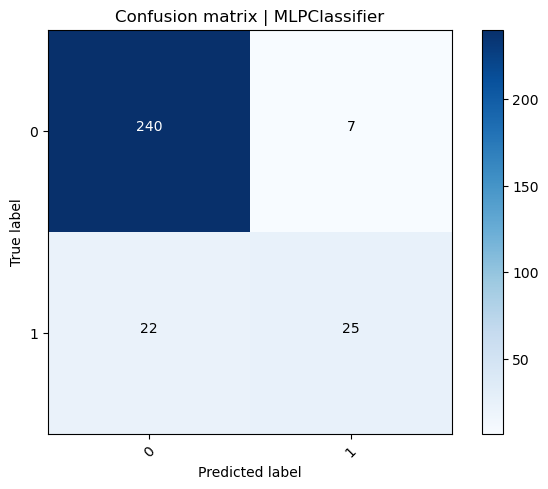

In [20]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred_test), classes=['0','1'],
                      title='Confusion matrix | MLPClassifier')

In [21]:
log_reg_model = LogisticRegression(C = 0.1, n_jobs=-1, random_state=RANDOM_SEED)
r_f_model = RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state = RANDOM_SEED)
hgbc_model = HistGradientBoostingClassifier(loss = 'log_loss', class_weight = 'balanced',  scoring = 'accuracy', random_state=RANDOM_SEED)
mlp_model = MLPClassifier(solver = 'adam', activation = 'relu', hidden_layer_sizes= [100, 100], shuffle = True, early_stopping = True, random_state = RANDOM_SEED)
svc_model = SVC(class_weight='balanced', probability = True, random_state=RANDOM_SEED)
cat_boosting_model = CatBoostClassifier(iterations=1000, learning_rate=0.01, depth=7, l2_leaf_reg=9, 
                              bootstrap_type='Bayesian', loss_function='Logloss', eval_metric='Accuracy', 
                              auto_class_weights='Balanced', allow_writing_files=False, silent = True)

models = [log_reg_model, r_f_model, hgbc_model, mlp_model, svc_model, cat_boosting_model]

# 5. Создание датафрейма по всем названиям моделей и значениям метрик

In [22]:
#data = [['tom', 10], ['nick', 15], ['juli', 14]] 
  
# Create the pandas DataFrame 
df_model = pd.DataFrame(columns=['model_name', 'accuracy_train', 'accuracy_test', 'f1_score', 'precision', 'recall', 'roc_auc']) 
df_model

,model_name,accuracy_train,accuracy_test,f1_score,precision,recall,roc_auc


In [23]:
for model in models:
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    y_pred_prob_test = model.predict_proba(X_test) 
    accuracy_score_test = accuracy_score(y_test, y_pred_test)
    accuracy_score_train = accuracy_score(y_train, y_pred_train)
    f1_test = f1_score(y_test, y_pred_test)
    precision_test = precision_score(y_test, y_pred_test)
    recall_test = recall_score(y_test, y_pred_test)
    roc_auc_test = roc_auc_score(y_test, y_pred_prob_test[:, 1])
    
    #print(f'Модель: {type(model).__name__}\nAccuracy_train: {accuracy_score_train}\nAccuracy_test: {accuracy_score_test}\nf1 score: {f1_test}\nPrecision: {precision_test}\nRecall: {recall_test}\nROC_AUC: {roc_auc_test}\n')
    new_row = {'model_name':type(model).__name__, 'accuracy_train':accuracy_score_train, 'accuracy_test':accuracy_score_test, 'f1_score':f1_test, 'precision':precision_test, 'recall':recall_test, 'roc_auc':roc_auc_test}
    df_model.loc[len(df_model)] = new_row
    #df_model = df_model.append(new_row, ignore_index=True)

In [24]:
df_model

,model_name,accuracy_train,accuracy_test,f1_score,precision,recall,roc_auc
0,LogisticRegression,0.947769,0.897959,0.583333,0.840000,0.446809,0.858127
1,RandomForestClassifier,1.000000,0.840136,0.253968,0.500000,0.170213,0.796580
2,HistGradientBoostingClassifier,1.000000,0.857143,0.363636,0.631579,0.255319,0.774830
3,MLPClassifier,0.962982,0.901361,0.632911,0.781250,0.531915,0.835989
4,SVC,0.966531,0.853741,0.245614,0.700000,0.148936,0.834439
5,CatBoostClassifier,0.994422,0.870748,0.441176,0.714286,0.319149,0.819881


In [25]:
len(df_model.model_name.unique())

6

# 6. Построение диаграмм с метриками для каждой модели

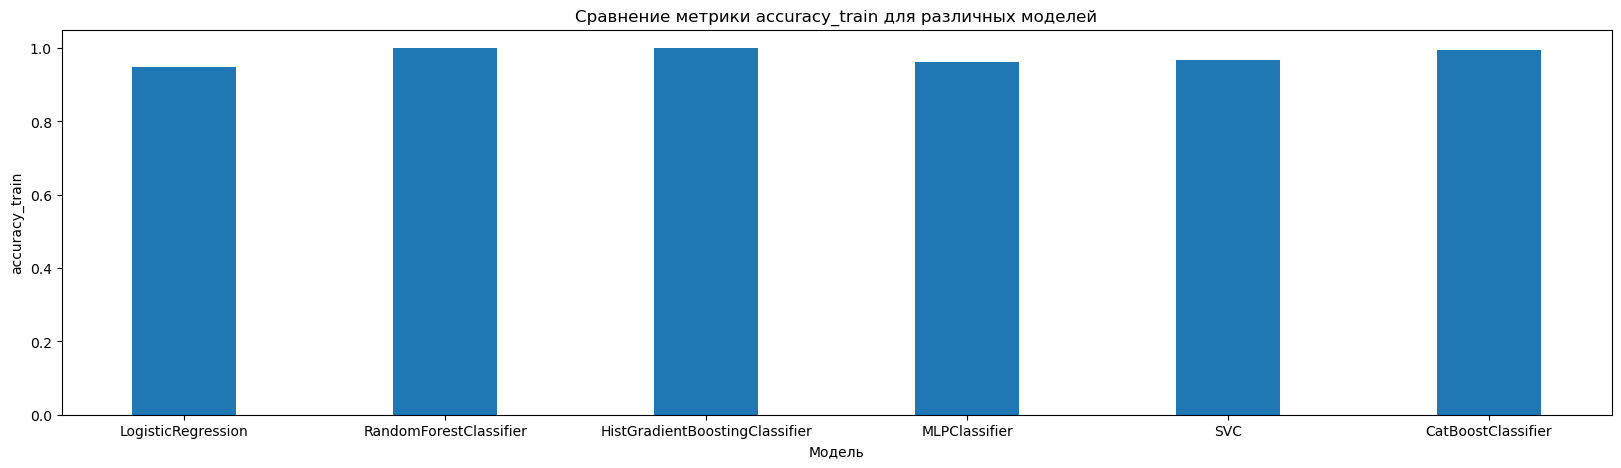

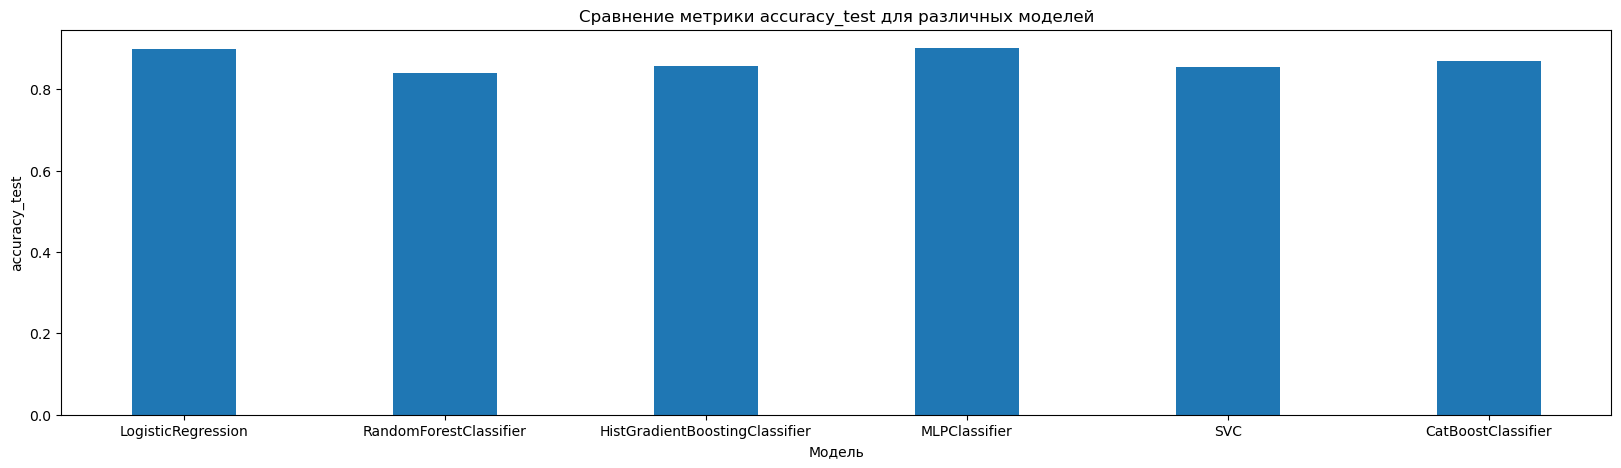

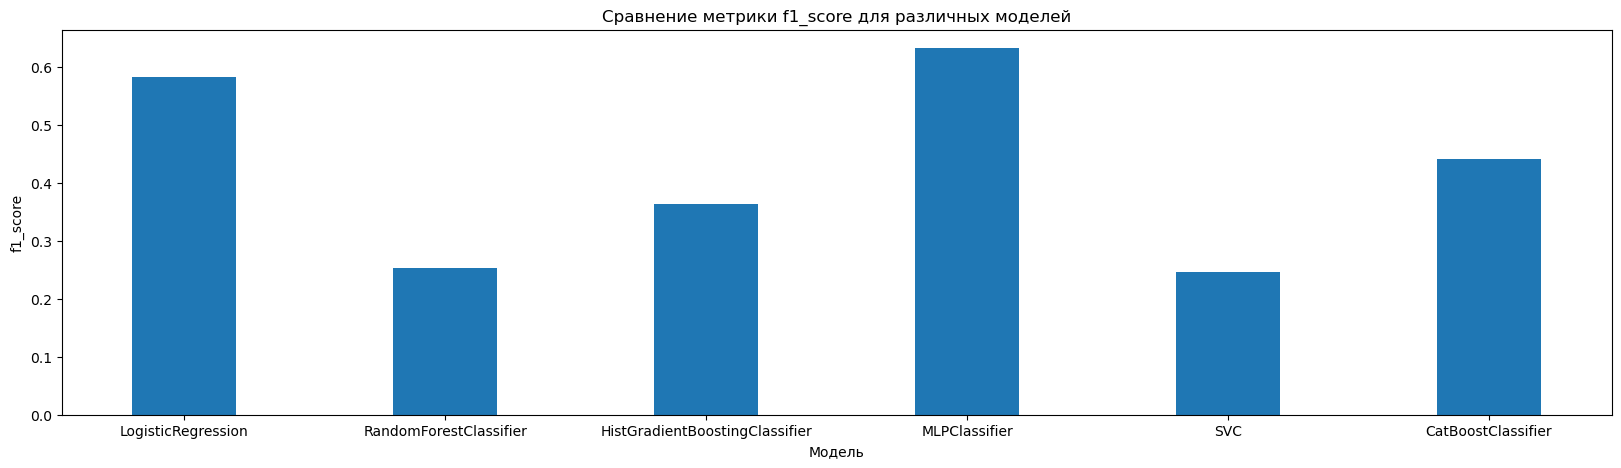

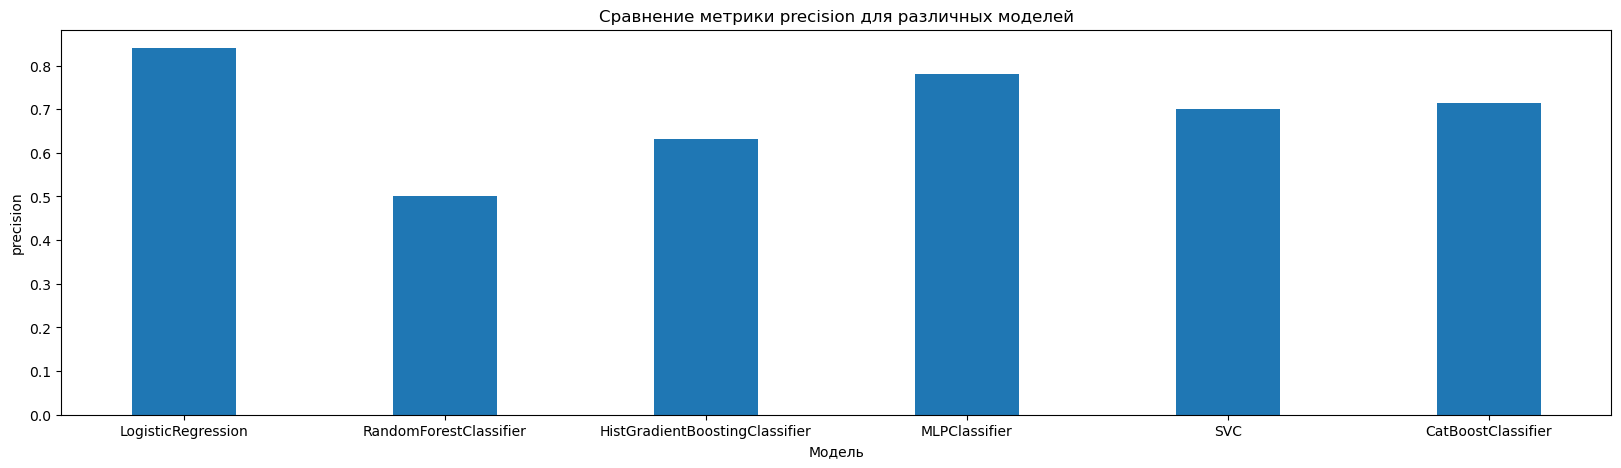

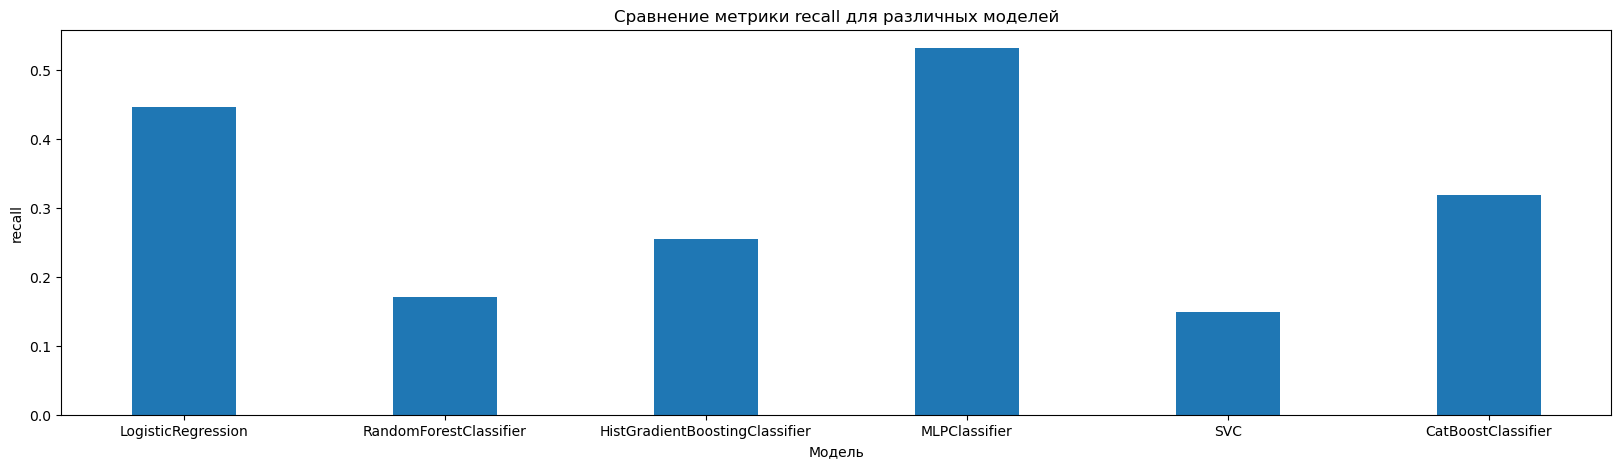

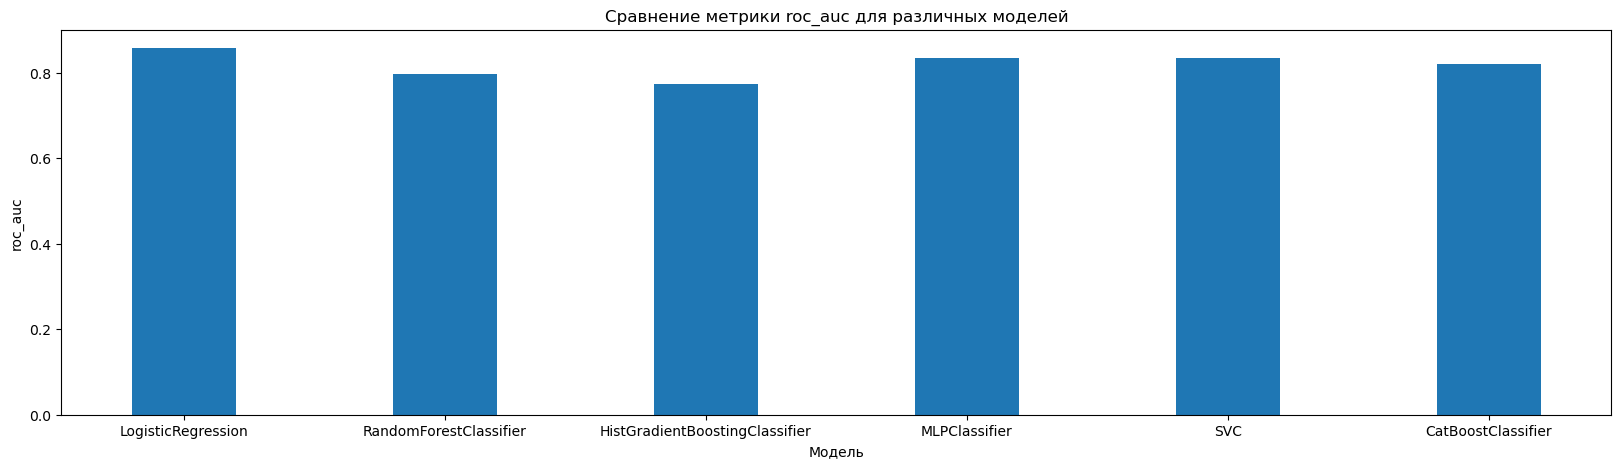

In [26]:
metrics = df_model.columns.drop('model_name')

x = df_model.model_name
y1 = df_model.accuracy_test 
y2 = df_model.f1_score 
y3 = df_model.precision 
y4 = df_model.recall 
y5 = df_model.roc_auc 

for metric in metrics:
    x = df_model.model_name
    y = df_model[metric] 
    width = 0.40
    fig, ax = plt.subplots(figsize=(20, 5))  
    # plot data in grouped manner of bar type 
    plt.bar(x, y, width)
    plt.xlabel('Модель');
    plt.ylabel(metric);
    plt.title (f'Сравнение метрики {metric} для различных моделей')
    #plt.bar(x, y2, width) 

    plt.show()

***Вывод:** Лучше всего с задачей классификации справились модели Логистической регресии и MLPClassifier, но метрика Recall выше у MLPClassifier, поэтому она показала лучшие результаты по качеству классификации. Исходных данных достаточно мало для обучения моделей, с возрастанием числа примеров для тренировочной выборки, качество моделей будет расти.*

# 7. Подбор параметров для лучшей модели

In [6]:
mpl_params = {
    #'hidden_layer_sizes': [np.arange(100, 1000, 100)],
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'alpha': np.arange(0.1, 1, 0.1),
    'batch_size': ['auto', np.arange(10, 100, 10)],
    'learning_rate': ['constant', 'invscaling', 'adaptive']
        }

gs_mpl = GridSearchCV(MLPClassifier(hidden_layer_sizes = [100, 100], shuffle = True, early_stopping = True, random_state = RANDOM_SEED), mpl_params, cv = 3, n_jobs = 10, scoring='accuracy',  error_score=0.0)
gs_mpl.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=0.0,
             estimator=MLPClassifier(early_stopping=True,
                                     hidden_layer_sizes=[100, 100],
                                     random_state=42),
             n_jobs=10,
             param_grid={'activation': ['identity', 'logistic', 'tanh', 'relu'],
                         'alpha': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                         'batch_size': ['auto',
                                        array([10, 20, 30, 40, 50, 60, 70, 80, 90])],
                         'learning_rate': ['constant', 'invscaling',
                                           'adaptive'],
                         'solver': ['lbfgs', 'sgd', 'adam']},
             scoring='accuracy')

In [7]:
print(f'params: {gs_mpl.best_params_}, score: {gs_mpl.best_score_}')

params: {'activation': 'identity', 'alpha': 0.5, 'batch_size': 'auto', 'learning_rate': 'constant', 'solver': 'adam'}, score: 0.8835034013605442


In [10]:
mlp_tun = MLPClassifier(hidden_layer_sizes = [100, 100], activation = 'identity', alpha = 0.5, batch_size = 'auto', learning_rate = 'constant', solver = 'adam', shuffle = True, early_stopping = True, random_state = RANDOM_SEED)

In [11]:
mlp_tun.fit(X_train, y_train)
y_pred_train = mlp_tun.predict(X_train)
y_pred_test =mlp_tun.predict(X_test)
y_pred_prob_test = mlp_tun.predict_proba(X_test) 
accuracy_score_test = accuracy_score(y_test, y_pred_test)
accuracy_score_train = accuracy_score(y_train, y_pred_train)
f1_test = f1_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
roc_auc_test = roc_auc_score(y_test, y_pred_prob_test[:, 1])
    
print(f'Модель: {type(mlp_tun).__name__}\nAccuracy_train: {accuracy_score_train}\nAccuracy_test: {accuracy_score_test}\nf1 score: {f1_test}\nPrecision: {precision_test}\nRecall: {recall_test}\nROC_AUC: {roc_auc_test}\n')

Модель: MLPClassifier
Accuracy_train: 0.9115646258503401
Accuracy_test: 0.8843537414965986
f1 score: 0.5
Precision: 0.8095238095238095
Recall: 0.3617021276595745
ROC_AUC: 0.8297010939788095



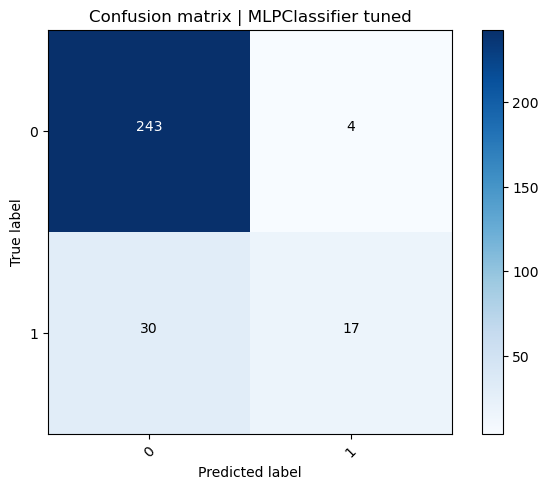

In [12]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred_test), classes=['0','1'],
                      title='Confusion matrix | MLPClassifier tuned')

*Использование подобранных с помощью GridSearchCV параметров ухудшило качество предсказаний модели.*

# 8. Вывод

***Для представленного датасета лучше всего подходит модель MLPClassifier, она показала лучшие результаты среди рассматриваемых моделей по метрикам точности и полнноты.
Тем не менее, доля правильно предсказанных фактов увольнения достаточно мала, это связано с малым количеством примеров - представителей мажорного класса, использованных в качестве тренировочной выборки. Генерация дополнительных примеров мажорного класса с целью создания сбалансированной тренировочной выборки позволила увеличить качество предсказания моделью мажорного класса(склонности к увольнению).***<br><br>
**Ответьте на вопрос: возможно ли создать кадровый резерв заранее с помощью ML?**<br>
*Можно, при наличии качественных и полных исходных данных*.

In [11]:
search_space = {
        'alpha': hp.quniform('alpha', 0.0, 100.0, 0.1),
        'batch_size': hp.quniform('batch_size', 10, 1000, 1),
        'activation': hp.choice('activation', ['identity', 'logistic', 'tanh', 'relu']),
        'solver': hp.choice('solver', ['lbfgs', 'sgd', 'adam']),
        'learning_rate': hp.choice('learning_rate', ['constant', 'invscaling', 'adaptive']),
    }

In [12]:
def objective(space):
    params = {
        'alpha': int(space['alpha']),
        'batch_size' : int(space['batch_size']),
        'activation': space['activation'],
        'solver': space['solver'],
        'learning_rate': space['learning_rate'],
        }
    
    clf = MLPClassifier(**params, shuffle = True, early_stopping = True, random_state = RANDOM_SEED)
   
    accuracy = cross_val_score(clf, X_train, y_train, scoring='accuracy', n_jobs= -1).mean()
    #print('SCORE:', accuracy)
    # Because fmin() tries to minimize the objective, this function must return the negative accuracy. 
    return {'loss': -accuracy, 'status': STATUS_OK}

In [14]:
trials = Trials()

In [15]:
with mlflow.start_run():
    best_hyperparams = fmin(fn = objective,
                       space=search_space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials,
                        show_progressbar=True
                       )

100%|██████████| 100/100 [01:04<00:00,  1.56trial/s, best loss: -0.8997185632590117]


In [16]:
print(hyperopt.space_eval(search_space, best_hyperparams))

{'activation': 'identity', 'alpha': 77.4, 'batch_size': 635.0, 'learning_rate': 'invscaling', 'solver': 'lbfgs'}


In [17]:
mlp_model = MLPClassifier(activation = 'identity', alpha = 77.4, batch_size = 635, learning_rate = 'invscaling', solver = 'lbfgs', shuffle = True, early_stopping = True, random_state = RANDOM_SEED)

In [18]:
mlp_model.fit(X_train, y_train)
y_pred_train = mlp_model.predict(X_train)
y_pred_test =mlp_model.predict(X_test)
y_pred_prob_test = mlp_model.predict_proba(X_test) 
accuracy_score_test = accuracy_score(y_test, y_pred_test)
accuracy_score_train = accuracy_score(y_train, y_pred_train)
f1_test = f1_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
roc_auc_test = roc_auc_score(y_test, y_pred_prob_test[:, 1])
    
print(f'Модель: {type(mlp_model).__name__}\nAccuracy_train: {accuracy_score_train}\nAccuracy_test: {accuracy_score_test}\nf1 score: {f1_test}\nPrecision: {precision_test}\nRecall: {recall_test}\nROC_AUC: {roc_auc_test}\n')

Модель: MLPClassifier
Accuracy_train: 0.9437119675456389
Accuracy_test: 0.8945578231292517
f1 score: 0.5753424657534246
Precision: 0.8076923076923077
Recall: 0.44680851063829785
ROC_AUC: 0.8544232922732363

